# Build hERG GNN model.

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm, NNConv
from rdkit import Chem
from rdkit.Chem import rdmolops
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

import pathlib
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
target = 'herg'
uniprot = 'Q12809'

In [3]:
# define paths
HERE = Path(pathlib.Path.cwd())
DATA = HERE / f"data_{target}"
DATA.mkdir(parents=True, exist_ok=True)

In [4]:
# Load chembl data

df = pd.read_csv(f'{DATA}/{target}_chembl.csv',index_col=None)
df['active'] = np.where(df['pIC50'] > 5, 1, 0) # 1=active, 0=inactive @ 10 uM
df.head(20)

,Index,molecule_chembl_id,IC50,units,units.1,smiles,pIC50,active
0,0,CHEMBL443476,88.0,nM,nM,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,7.055517,1
1,1,CHEMBL53661,137.0,nM,nM,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,6.863279,1
2,2,CHEMBL299390,1480.0,nM,nM,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,5.829738,1
3,3,CHEMBL12186,10.0,nM,nM,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)c...,8.000000,1
4,4,CHEMBL556312,23.5,nM,nM,O=C1NCCN1CCN1CCC(C2CN(c3ccc(F)cc3)c3ccccc32)CC1,7.628932,1
5,5,CHEMBL1729,45.0,nM,nM,COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)C...,7.346787,1
6,6,CHEMBL6966,143.0,nM,nM,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,6.844664,1
7,7,CHEMBL55835,579.0,nM,nM,O=C(O)Cc1ccc(-n2cc(C3CCN(CCN4CCNC4=O)CC3)c3cc(...,6.237321,1
8,8,CHEMBL17157,56.0,nM,nM,CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccc...,7.251812,1
9,9,CHEMBL298978,6.2,nM,nM,Fc1ccc(-n2cc(C3CCN(CCN4CCN=C4S)CC3)c3ccccc32)cc1,8.207608,1


In [23]:
# take a random sample from Chembl dataset to ensure it is balanced

n_samples_per_class = 1000

# Sample n samples from each class randomly
df_herg = pd.concat([
    df[df['active'] == 0].sample(n=n_samples_per_class, random_state=42),
    df[df['active'] == 1].sample(n=n_samples_per_class, random_state=42)
])

df_herg = df_herg.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_herg['active'].value_counts())

active
1    1000
0    1000
Name: count, dtype: int64


In [24]:
smiles_list = df_herg.smiles.to_list()
labels = df_herg.active.to_list()

In [25]:
# One-hot encoder with "unknown" category fallback

def one_hot_encoding(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]  # unknown
    return [int(x == s) for s in allowable_set]

def get_atom_features(atom):
    features = []
    features += one_hot_encoding(atom.GetSymbol(),
                                  ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'H', 'other'])
    features += one_hot_encoding(atom.GetHybridization(),
                                  [Chem.rdchem.HybridizationType.SP,
                                   Chem.rdchem.HybridizationType.SP2,
                                   Chem.rdchem.HybridizationType.SP3,
                                   Chem.rdchem.HybridizationType.SP3D,
                                   Chem.rdchem.HybridizationType.SP3D2,
                                   Chem.rdchem.HybridizationType.UNSPECIFIED])
    features += [atom.GetDegree()]  # Number of bonds
    features += [atom.GetFormalCharge()]
    features += [atom.GetNumRadicalElectrons()]
    features += [int(atom.GetIsAromatic())]
    return np.array(features, dtype=np.float32)

def get_bond_features(bond):
    bond_type = bond.GetBondType()
    return np.array([
        int(bond_type == Chem.rdchem.BondType.SINGLE),
        int(bond_type == Chem.rdchem.BondType.DOUBLE),
        int(bond_type == Chem.rdchem.BondType.TRIPLE),
        int(bond_type == Chem.rdchem.BondType.AROMATIC),
        int(bond.GetIsConjugated()),
        int(bond.IsInRing()),
    ], dtype=np.float32)

In [26]:
def mol_to_graph(smiles: str, label: int):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features, dtype=torch.float)

    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        bond_feat = get_bond_features(bond)

        # Add edges in both directions
        edge_index += [[i, j], [j, i]]
        edge_attr += [bond_feat, bond_feat]

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    y = torch.tensor([label], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [27]:
data_list = []

for smi, lbl in zip(smiles_list, labels):
    data = mol_to_graph(smi, lbl)
    if data is not None:
        data_list.append(data)

from torch_geometric.loader import DataLoader

loader = DataLoader(data_list, batch_size=16, shuffle=True)

In [28]:
# Use a GNN model, as it is 'good enough'.

class GCN(torch.nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim=128):
        super().__init__()

        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(edge_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, input_dim * hidden_dim) 
        )

        self.conv1 = NNConv(input_dim, hidden_dim, self.edge_mlp, aggr='mean')

        self.edge_mlp2 = torch.nn.Sequential(
            torch.nn.Linear(edge_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim * hidden_dim)
        )

        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_mlp2, aggr='mean')

        self.lin = torch.nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))

        x = global_mean_pool(x, batch)
        return self.lin(x).squeeze(1)


In [29]:
# input_dim = data_list[0].x.shape[1]
# edge_dim = data_list[0].edge_attr.shape[1]
# model = GCN(input_dim, edge_dim).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# loss_fn = torch.nn.BCEWithLogitsLoss()

# model.train()

# for epoch in range(100):
#     total_loss = 0
#     for batch in loader:
#         batch = batch.to(device)
#         optimizer.zero_grad()
#         out = model(batch)

#         # Ensure batch.y is shape [batch_size]
#         y = batch.y.view(-1)

#         loss = loss_fn(out, y)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

### With early stopping

In [30]:
from sklearn.model_selection import train_test_split

# Assuming you have a PyG dataset list: data_list
train_list, val_list = train_test_split(data_list, test_size=0.2, random_state=42, stratify=[d.y.item() for d in data_list])

train_loader = DataLoader(train_list, batch_size=32, shuffle=True)
val_loader = DataLoader(val_list, batch_size=32)

In [31]:
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = loss_fn(out, batch.y.float())
            total_loss += loss.item()
    return total_loss / len(loader)


In [ ]:
# Training with early stopping implmented. 

def train_with_early_stopping(params):
    model = GCN(input_dim=params['input_dim'], edge_dim=params['edge_dim'], hidden_dim=params['hidden_dim']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=params.get('pos_weight'))

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss = eval_epoch(model, val_loader, loss_fn, device)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Load best model weights
    model.load_state_dict(torch.load('best_model.pth'))
    return model


With hyperparameter tuning.

In [43]:
import itertools

input_dim = data_list[0].x.shape[1]
edge_dim = data_list[0].edge_attr.shape[1] if data_list[0].edge_attr is not None else 0

param_grid = {
    'lr': [0.01, 0.001],
    'hidden_dim': [64, 128],
    'pos_weight': [None, torch.tensor([2.0], device=device)]  # Example for weighted loss
}

best_model = None
best_val_loss = float('inf')
best_params = None

for lr, hidden_dim, pos_weight in itertools.product(param_grid['lr'], param_grid['hidden_dim'], param_grid['pos_weight']):
    params = {
        'lr': lr,
        'hidden_dim': hidden_dim,
        'pos_weight': pos_weight,
        'input_dim': input_dim,
        'edge_dim': edge_dim
    }
    print(f"Training with lr={lr}, hidden_dim={hidden_dim}, pos_weight={pos_weight}")
    # params = {'lr': lr, 'hidden_dim': hidden_dim, 'pos_weight': pos_weight, 'input_dim': input_dim}
    model = train_with_early_stopping(params)
    
    val_loss = eval_epoch(model, val_loader, torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight), device)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_params = params

print(f"Best params: {best_params}")

Training with lr=0.01, hidden_dim=64, pos_weight=None
Epoch 1 | Train Loss: 0.7047 | Val Loss: 0.6930
Epoch 2 | Train Loss: 0.6934 | Val Loss: 0.6916
Epoch 3 | Train Loss: 0.6907 | Val Loss: 0.6843
Epoch 4 | Train Loss: 0.6840 | Val Loss: 0.6760
Epoch 5 | Train Loss: 0.6771 | Val Loss: 0.6848
Epoch 6 | Train Loss: 0.6763 | Val Loss: 0.6794
Epoch 7 | Train Loss: 0.6761 | Val Loss: 0.6758
Epoch 8 | Train Loss: 0.6686 | Val Loss: 0.6825
Epoch 9 | Train Loss: 0.6742 | Val Loss: 0.6664
Epoch 10 | Train Loss: 0.6650 | Val Loss: 0.6668
Epoch 11 | Train Loss: 0.6592 | Val Loss: 0.6582
Epoch 12 | Train Loss: 0.6600 | Val Loss: 0.6611
Epoch 13 | Train Loss: 0.6543 | Val Loss: 0.6562
Epoch 14 | Train Loss: 0.6583 | Val Loss: 0.6591
Epoch 15 | Train Loss: 0.6558 | Val Loss: 0.6580
Epoch 16 | Train Loss: 0.6468 | Val Loss: 0.6526
Epoch 17 | Train Loss: 0.6405 | Val Loss: 0.6617
Epoch 18 | Train Loss: 0.6377 | Val Loss: 0.6548
Epoch 19 | Train Loss: 0.6408 | Val Loss: 0.6515
Epoch 20 | Train Loss: 0

Without hyperparameter tuning.

In [ ]:
# train_list, val_list = train_test_split(
#     data_list, test_size=0.2, random_state=42,
#     stratify=[d.y.item() for d in data_list]
# )
# train_loader = DataLoader(train_list, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_list, batch_size=32)

# # 2. Get input_dim from your data (assuming node features in data.x)
# input_dim = data_list[0].x.shape[1]
# edge_dim = data_list[0].edge_attr.shape[1] if data_list[0].edge_attr is not None else 0

# # 3. Define hyperparameters
# params = {
#     'input_dim': input_dim,
#     'edge_dim': edge_dim,
#     'hidden_dim': 64,
#     'lr': 0.001,
#     'pos_weight': None  # or torch.tensor([...]) if using weighted loss
# }

# # 4. Call the training loop
# model = train_with_early_stopping(params)


# Evaluation


 Accuracy: 0.7850
 ROC AUC: 0.8782


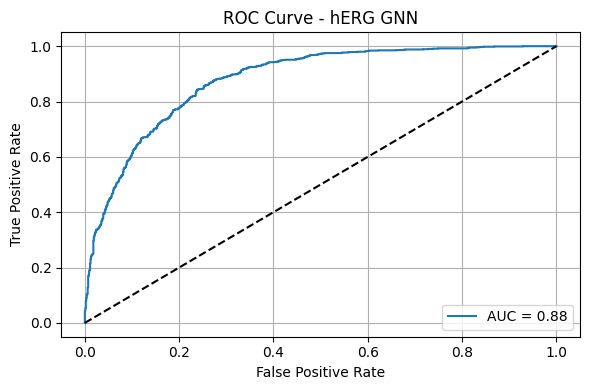

In [48]:
model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)
        probs = torch.sigmoid(logits)
        y_true.extend(batch.y.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_pred = [1 if p > 0.5 else 0 for p in y_scores]

acc = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_scores)
fpr, tpr, _ = roc_curve(y_true, y_scores)

print(f"\n Accuracy: {acc:.4f}")
print(f" ROC AUC: {roc_auc:.4f}")

# 8. Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - hERG GNN")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

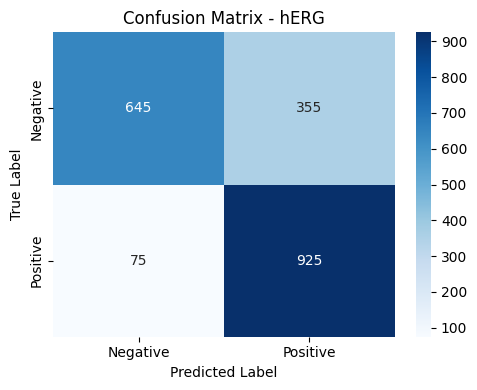

In [47]:
# Confusion matrix is more informative than ROC

cm = confusion_matrix(y_true, y_pred)
conf_mat_labels = ['Negative', 'Positive']

# 10. Plot confusion matrix heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=conf_mat_labels, yticklabels=conf_mat_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - hERG')
plt.tight_layout()
plt.show()

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=conf_mat_labels))

              precision    recall  f1-score   support

    Negative       0.90      0.65      0.75      1000
    Positive       0.72      0.93      0.81      1000

    accuracy                           0.79      2000
   macro avg       0.81      0.79      0.78      2000
weighted avg       0.81      0.79      0.78      2000



In [37]:
torch.save(model.state_dict(), "herg_gnn.pt")